# Reparameterization Trick

## 0. Initialize

In [1]:
using LinearAlgebra
using Statistics
using Distributions
using Random
using ProgressMeter
using ForwardDiff
using Plots
using UnPack

## 1. Define functions and structures

In [2]:
#initialize the parameter
function init_params(data_params)
    @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(params_vec, data_params)
    @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    W = reshape(params_vec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function Φ(x, wvec, data_params)
   @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    W₂, W₃, b₂, b₃ = reshape_params(wvec, data_params)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

#plot the data and return the figure
function plot_data(X, Y)
    _, N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#plot the probability to classify new data to class 1(red point)
function plot_prob_1(X, Y, wvec, data_params, title)
    T = 40
    X1s = range(0,1,length=T)
    X2s = range(0,1,length=T)
    preds = zeros(T,T)
    @showprogress for j in 1:T
        x2 = X2s[j]
        for i in 1:T
            x1 = X1s[i]
            preds[i,j] = ppred([x1,x2], wvec, data_params)
        end
    end
    fig = heatmap(X1s, X2s, preds, c=cgrad(:coolwarm), alpha=0.6, title=title)
    return plot_data(fig, X, Y)
end

plot_prob_1 (generic function with 1 method)

## 2. Create the data

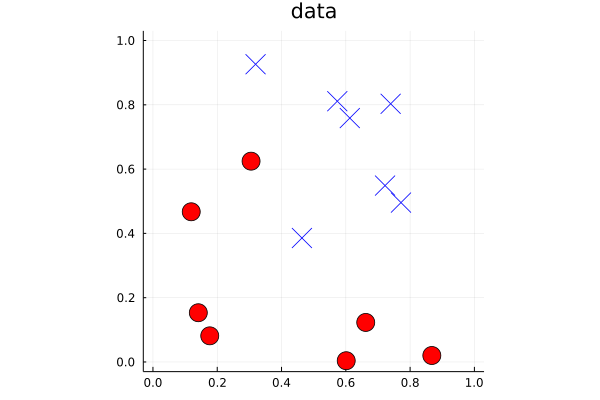

In [3]:
#create the data
Random.seed!(46)
N = 14
X = hcat(rand(Beta(1.1,3), 2, div(N,2)), rand(Beta(1.9,1.1), 2, div(N,2)))
Y = vcat(vcat(ones(div(N,2)), zeros(div(N,2)))', vcat(zeros(div(N,2)), ones(div(N,2)))')

#plot the data
fig1 = plot_data(X, Y)
savefig(fig1, "figs-RT/fig1.png")
fig1

## 3. Training a "classical" NeuralNetwork

In [4]:
# loss function 
Ln(y_pred, y_data) = norm(y_pred-y_data)^2

#train the neural network
function train_nn(wvec, data_params, n_train, tol, ϵ)
    @unpack X, Y, N, Dx, Dy, D₀ = data_params
    
    #gradient of the loss function
    ∇Ln(wvec, idx) = ForwardDiff.gradient(wvec->Ln(Φ(X[:,idx], wvec, data_params), Y[:,idx]), wvec)
    
    @showprogress for i in 1:n_train
        #choose the sample uniformaly
        idx = rand(1:N)
        
        #gradient descent
        wvec = wvec - ϵ*∇Ln(wvec, idx)
    end
    return wvec
end

#predict the class for new data
function ppred(x, wvec, data_params)
    pred = Φ(x, wvec, data_params)
    return pred[1]/sum(pred)
end

ppred (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:0839m


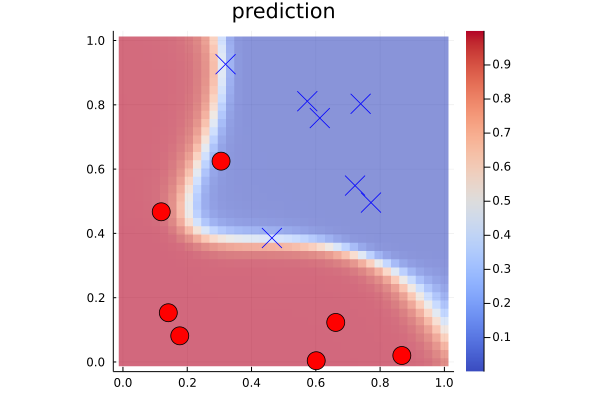

In [5]:
#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
data_params = (X=X, Y=Y, N=N, Dx=Dx, Dy=Dy, D₀=D₀)
W₂, W₃, b₂, b₃ = init_params(data_params)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]

#train the network
n_train = Int(1e6)
tol = 1e-5 #tolerance of SGD
ϵ = 1e-1 #learning rate of SGD
wvec = train_nn(wvec₀, data_params, n_train, tol, ϵ)

#predict
fig2 = plot_prob_1(X, Y, wvec, data_params, "prediction")
savefig(fig2, "figs-RT/fig2.png")
fig2

## 4. Probabilistic Variational Inference + reparameterization trick

In [6]:
#logpprior, logpmodel, logpposterior, logplik
logpprior(λw) = logpdf(Normal(0, 1/√λw), w)
logpmodel(y, x, wvec, data_params) = log(dot(y, Φ(x, wvec, data_params))/sum(Φ(x, wvec, data_params)))
function loglik(wvec, data_params)
    @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    return sum([logpmodel(Y[:,n], X[:,n], wvec, data_params) for n in 1:N])
end

function logppost(wvec, λw, data_params)
    @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    return sum(logpprior(wvec,λw)) + loglik(wvec, data_params)
end

#predictive: returns the probability to new data classify to class 1
function ppred(x, wsamps, data_params)
    _, n_samps = size(wsamps)
    preds = zeros(n_samps)
    for i in 1:n_samps
        preds[i] = exp(logpmodel([1,0], x, wsamps[:,i], data_params))
    end
    return mean(preds)
end

#reparametrization function 
reparam_func(ϵvec, θvec, d) = θvec[1:d] + ϵvec ./ sqrt.(θvec[d+1:end])

#derivative
Jϵ(ϵvec, θvec, d) = ForwardDiff.jacobian(θvec->reparam_func(ϵvec, θvec, d), θvec)
∇logpmodel(y, x, ϵvec, θvec, d, data_params) = ForwardDiff.gradient(wvec->logpmodel(y, x, wvec, data_params), reparam_func(ϵvec, θvec, d))
    
#MC approximation : expectation with respect to r(w)
function Er(x, y, θvec, S, data_params)
    θdim = length(θvec)
    d = div(θdim, 2)
    ϵsamp = rand(d)
    Ersamp = zeros(θdim)
    for s in 1:S
        ϵsamp = rand(d)
        Ersamp += Jϵ(ϵsamp, θvec, d)' * ∇logpmodel(y, x, ϵsamp, θvec, d, data_params)
    end
    return Ersamp/S
end

#gradient Kullback-Leibler divergence with respect to variational parameter
function ∇DKL(θvec, λw)
    d = div(length(θvec), 2)
    μs = θvec[1:d]
    λs = θvec[d+1:end]
    ∇μDKL = λw * μs
    ∇λDKL = (1 ./λs - λw./λs.^2)/2
    return vcat(∇μDKL, ∇λDKL)
end

#variational infernce
function myVI(data_params, λw, d, n_train, S, α)
    @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    θvec = vcat(zeros(d), ones(d))
    @showprogress for k in 1:n_train
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[:,idx]
        θvec += α * (N * Er(x, y, θvec, S, data_params) - ∇DKL(θvec, λw))
    end
    return θvec
end

#sample from posterior
function sample_from_posterior(θvec, n_samps)
    d = div(length(θvec), 2)
    wsamps = zeros(d, n_samps)
    for j in 1:d
        μj = θvec[j]
        λj = θvec[d+j]
        wsamps[j,:] = rand(Normal(μj, 1/√λj), n_samps)
    end
    return wsamps
end

#calculate WAIC
function calc_WAIC(wsamps, data_params)
    @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    _,n_samps = size(wsamps)
    logpreds = zeros(N)
    vars = zeros(N)
    for n in 1:N
        logpreds[n] = -log(mean([exp(logpmodel(Y[:,n], X[:,n], wsamps[:,i], data_params)) for i in 1:n_samps]))
        vars[n] = var([logpmodel(Y[:,n], X[:,n], wsamps[:,i], data_params) for i in 1:n_samps])
    end
    return mean(logpreds) + mean(vars)
end

#model selection
function model_selection(data_params, λws, d, n_train, n_samps, S, α)
    @unpack  X, Y, N, Dx, Dy, D₀ = data_params
    M = length(λws)
    WAICs = zeros(M)
    for i in 1:M
        θvec = myVI(data_params, λws[i], d, n_train, S, α)    
        wsamps = sample_from_posterior(θvec, n_samps)
        WAICs[i] = calc_WAIC(wsamps, data_params)
    end
    return WAICs
end

model_selection (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


λw=99.99999999999999 minimize WAIC (std=0.1). 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


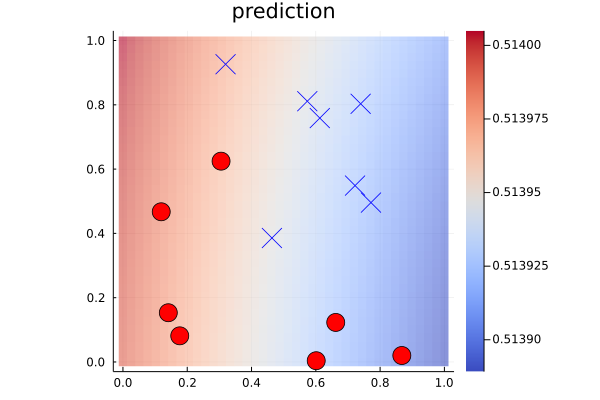

In [7]:
#data parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
data_params = (X=X, Y=Y, N=N, Dx=Dx, Dy=Dy, D₀=D₀)

#model parameters
W₂, W₃, b₂, b₃ = init_params(data_params)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]
d = length(wvec₀)

#model selection
α = 0.01
S = 100
n_train = 1000
n_samps = 5000
λws = 1 ./ collect(0.1:0.1:1.0) .^2
WAICs = model_selection(data_params, λws, d, n_train, n_samps, S, α)
λw = λws[argmin(WAICs)]
println("λw=$(λw) minimize WAIC (std=$(1/sqrt(λw))). ")

#variational parameters
θvec = myVI(data_params, λw, d, n_train, S, α)

#posterior sample
wsamps = sample_from_posterior(θvec, n_samps)

#plot the prediction
fig3 = plot_prob_1(X, Y, wsamps, data_params, "prediction")
savefig(fig3, "figs-RT/fig3.png")
fig3